# __Rangement d'un tuyau de jardin__

Auguste Pierfitte et Cécile-Aurore Wotawa

On commence par importer les modules nécessaires. Nous avons choisi le module d'optimisation CasADi.

## Imports des dépendances

In [32]:
from casadi import *
import time
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# on fixe la longueur du tuyau

L = 10

## Réponse aux questions

### 1. Étude du problème d'optimisation

#### __Question 1 :__

Minimiser le premier terme du coût (4) permet de rapprocher la fin du tuyau (abscisse $x_N$) le plus proche possible du parterre de fleurs.

Minimiser le deuxième terme permet d'éviter que les ordonnées $y_i$ s'éloignent trop de l'axe $y=0$. Ainsi, le tuyau prend moins de place dans le jardin !

#### Question 2 :

Dans un premier temps, il n'est pas nécessaire d'être précisèment sur le parterre de fleurs pour pouvoir l'arroser.

Dans un second temps, d'un point de vue plus pragmatique, respecter la condition $\frac{L}{2}$ imposerait de fournir une solution initiale proche de la solution recherchée : ce qui complexifierait le problème. De plus, on prend déjà en compte cette condition dans la fonction à minimiser. Le facteur $K$ permet de donner plus ou moins d'importance à cet aspect.

#### Question 3 :

Cette condition impose que le tuyau d'arrosage ne "plie" pas trop.

En effet, elle impose qu'on puisse "insérer une courbe de degré 2 et de coefficient $\gamma$" entre 3 points successifs.


#### Question 4 :

- La variable de décision $z$ est un vecteur de $\mathbb{R}^{2(N + 1)}$, représentant les N+1 points $(x_i, y_i)$ : $z = ((x_0, y_0), ..., (x_N, y_N))$
- Il y a N+1 couples de variables de la forme $(x_i, y_i)$
- Pour les contraintes $c_{eq}$ :
    - $c_{eq_1}^i(z) = (x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2 - dx^2$, pour $0 \leq i \leq N-1$
    - $c_{eq_2}(z) = x_0$
    - $c_{eq_3}(z) = y_0$
    - $c_{eq_4}(z) = y_N$
    
Ce qui invite à poser $c_{eq}(z) = (c_{eq_1}^0(z), ..., c_{eq_1}^{N-1}(z), c_{eq_2}(z), c_{eq_3}(z), c_{eq_4}(z))$

- Pour les contraintes $c_{ineq}$ :
    - $ c_{ineq_1}^i(z) = x_i - x_{i+1}$, pour $0 \leq i \leq N-1$
    - $c_{ineq_2}^i(z) = (x_{i+1} - 2x_i + x_{i-1})^2 + (y_{i+1} - 2y_i + y_{i-1})^2 - dx^4\gamma^2$, pour $1 \leq i \leq N-1$
    - $c_{ineq_3}(z) = -y_1$
    
Ce qui invite à poser $c_{ineq}(z) = (c_{ineq_1}^0(z), ..., c_{ineq_1}^{N-1}(z), c_{ineq_2}^1(z), ..., c_{ineq_2}^{N-1}(z), c_{ineq_3}(z))$

- Finalement, la fonction objectif $f$ à minimiser est la suivante :
$f(z) = K(x_N - \frac{L}{2})^2 + dx^2\sum_{i=0}^{N}y_i^2$

### 2. Étude et résolution numériques

#### Question 5 :

**TODO**

#### Question 6 :

In [34]:
def resol_pb(K = 10, N = 60, gamma = 3):
    
    # déclaration des variables
    
    dx = L/N
    
    # déclaration du solveur et de la variable de décision

    opti = casadi.Opti();
    z = opti.variable(2, N+1)

    # définition de la fonction à minimiser

    f = K*(z[0,-1] - L/2)**2
    for i in range(N+1):
        f += (dx*z[1,i])**2

    # optimisation sous contraintes

    opti.minimize(f)

    for i in range(N):
        opti.subject_to((z[0,i+1]-z[0,i])**2 + (z[1,i+1]-z[1,i])**2 - dx**2 == 0)
        opti.subject_to(z[0,i]-z[0,i+1] <= 0)
        if i != 0:
            opti.subject_to((z[0,i+1]-2*z[0,i]+z[0,i-1])**2+(z[1,i+1]-2*z[1,i]+z[1,i-1])**2-(dx**4)*(gamma**2) <= 0)

    opti.subject_to(z[1,-1] == 0)
    opti.subject_to(z[0,0] == 0)
    opti.subject_to(z[1,0] == 0)
    opti.subject_to(z[1,1] >= 0)

    # condition initiale : le tuyau d'arrosage est déplié sur toute sa longueur
    # z0 = np.array([np.linspace(0, L, N+1), np.zeros(N+1)])

    # déclaration de la condition initiale : triangle isocèle rectangle
    Y = np.empty(N + 1)
    Y[:N//2] = np.linspace(0, L/(2*np.sqrt(2)), N//2)
    Y[N//2:] = L/(2*np.sqrt(2)) - np.linspace(dx/(2*np.sqrt(2)), L/(2*np.sqrt(2)), N//2 + 1)
    z0 = np.array([np.linspace(0, L/np.sqrt(2), N+1), Y])

    opti.set_initial(z, z0)

    # choix du solveur
    opti.solver('ipopt')

    # on laisse la magie opérer
    sol = opti.solve()
    
    return(sol.value(z), z0)



In [35]:
sol, z0 = resol_pb()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      475
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 103  3.6988486e-01 1.33e-05 2.09e-02  -5.7 6.41e-03  -0.2 8.38e-01 9.38e-01f  1
 104  3.6969258e-01 1.63e-05 3.81e-02  -5.7 3.81e-02  -0.7 4.83e-01 9.40e-02f  1
 105  3.6913873e-01 2.85e-05 5.23e-03  -5.7 9.51e-03  -0.3 1.00e+00 1.00e+00f  1
 106  3.6899072e-01 2.88e-05 6.03e-02  -5.7 5.52e-02  -0.7 4.51e-01 3.64e-02h  1
 107  3.6896559e-01 2.70e-05 4.12e-01  -5.7 6.86e-03  -0.3 8.48e-01 6.31e-02f  1
 108  3.6871859e-01 3.44e-05 2.81e-01  -5.7 8.75e-02  -0.8 3.35e-01 9.16e-02f  1
 109  3.6844166e-01 4.01e-05 3.22e-01  -5.7 1.06e-02  -0.4 4.30e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.6840744e-01 4.01e-05 3.12e-01  -5.7 1.73e-01  -0.8 1.28e-01 3.28e-03h  1
 111  3.6830184e-01 3.77e-05 4.57e-01  -5.7 1.92e-02  -0.4 1.00e+00 8.32e-02f  1
 112  3.6759177e-01 1.20e-04 4.53e-01  -5.7 3.88e-01  -0.9 8.32e-02 3.56e-02f  1
 113  3.6753834e-01 1.12e-04 4.30e-01  -5.7 1.58e-02  -0.5 5.94e-01 6.43e-02h  1
 114  3.6704679e-01 5.55e-06

Number of Lagrangian Hessian evaluations             = 291
Total CPU secs in IPOPT (w/o function evaluations)   =      0.473
Total CPU secs in NLP function evaluations           =      0.157

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.62ms ( 21.57us)   6.74ms ( 21.95us)       307
       nlp_g  |  34.83ms (113.46us)  35.01ms (114.03us)       307
  nlp_grad_f  |   7.77ms ( 26.52us)   7.89ms ( 26.94us)       293
  nlp_hess_l  |  55.49ms (190.68us)  55.85ms (191.91us)       291
   nlp_jac_g  |  55.90ms (190.79us)  56.28ms (192.10us)       293
       total  | 705.97ms (705.97ms) 690.10ms (690.10ms)         1


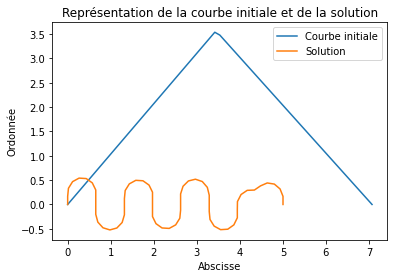

In [36]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution")

plt.plot(z0[0], z0[1], label="Courbe initiale")
plt.plot(sol[0][:], sol[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

#### Question 7 :

##### Cas K = 100

In [37]:
sol1 = resol_pb(K = 100)[0]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      475
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

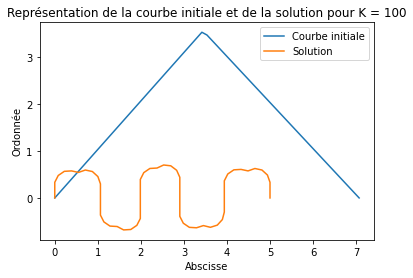

In [38]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution pour K = 100")

plt.plot(z0[0], z0[1], label="Courbe initiale")
plt.plot(sol1[0][:], sol1[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

##### Cas K = $10^5$

In [39]:
sol2 = resol_pb(K = 100000)[0]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      475
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 244  3.6045951e-01 8.33e-06 6.54e-06  -8.6 5.45e-03  -4.3 1.00e+00 3.36e-01h  2
 245  3.6035899e-01 6.25e-06 2.24e-05  -8.6 6.81e-03  -4.8 1.00e+00 4.01e-01h  1
 246  3.6033731e-01 5.59e-06 2.27e-05  -8.6 3.45e-02    -  2.61e-01 1.06e-01f  2
 247  3.6028167e-01 4.93e-06 5.45e-08  -8.6 5.14e-03  -5.3 1.00e+00 1.00e+00h  1
 248  3.6028324e-01 5.89e-06 1.23e-05  -8.6 3.99e-02  -5.8 2.43e-01 6.18e-02h  5
 249  3.6029178e-01 1.13e-05 9.72e-08  -8.6 9.67e-03  -5.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  3.6022407e-01 2.96e-06 6.85e-08  -8.6 5.06e-03  -4.9 1.00e+00 1.00e+00h  1
 251  3.6019917e-01 5.43e-07 7.15e-08  -8.6 2.17e-03  -4.5 1.00e+00 1.00e+00h  1
 252  3.6014895e-01 9.80e-06 1.22e-07  -8.6 9.17e-03  -5.0 1.00e+00 1.00e+00h  1
 253  3.6006308e-01 2.29e-06 1.37e-07  -8.6 4.52e-03  -4.5 1.00e+00 1.00e+00h  1
 254  3.6000749e-01 1.16e-05 2.09e-05  -8.6 3.12e-02  -5.0 6.07e-01 1.98e-01h  2
 255  3.5996841e-01 2.27e-06

Dual infeasibility......:   4.2928271837727234e-11    1.7781472404425603e-07
Constraint violation....:   5.4960350159838356e-09    5.4960350159838356e-09
Complementarity.........:   2.5067310877411664e-09    1.0383220137646517e-05
Overall NLP error.......:   5.4960350159838356e-09    1.0383220137646517e-05


Number of objective function evaluations             = 470
Number of objective gradient evaluations             = 356
Number of equality constraint evaluations            = 470
Number of inequality constraint evaluations          = 470
Number of equality constraint Jacobian evaluations   = 356
Number of inequality constraint Jacobian evaluations = 356
Number of Lagrangian Hessian evaluations             = 355
Total CPU secs in IPOPT (w/o function evaluations)   =      0.513
Total CPU secs in NLP function evaluations           =      0.155

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.60ms ( 14.05us)   6.73ms ( 1

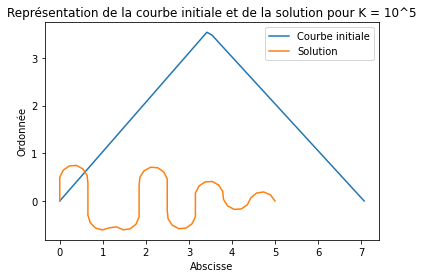

In [40]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution pour K = 10^5")

plt.plot(z0[0], z0[1], label="Courbe initiale")
plt.plot(sol2[0][:], sol2[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

##### Comparaison des solutions

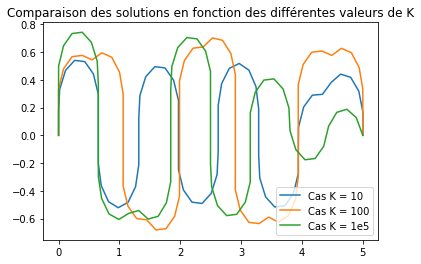

In [41]:
plt.title("Comparaison des solutions en fonction des différentes valeurs de K")

plt.plot(sol[0][:], sol[1][:], label="Cas K = 10")
plt.plot(sol1[0][:], sol1[1][:], label="Cas K = 100")
plt.plot(sol2[0][:], sol2[1][:], label="Cas K = 1e5")

plt.legend()
plt.show()

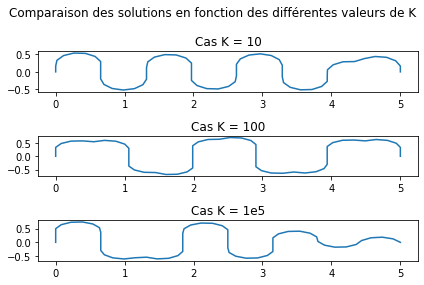

In [42]:
fig, ax = plt.subplots(3)

fig.suptitle("Comparaison des solutions en fonction des différentes valeurs de K")

ax[0].plot(sol[0][:], sol[1][:])
ax[0].set_title("Cas K = 10")
ax[1].plot(sol1[0][:], sol1[1][:])
ax[1].set_title("Cas K = 100")
ax[2].plot(sol2[0][:], sol2[1][:])
ax[2].set_title("Cas K = 1e5")

fig.tight_layout()
plt.show()

On constate qu'en augmentant la valeur de K, on rapproche la fin du tuyau du point $(\frac{L}{2}, 0)$.

Néanmoins, la régularité de la courbe obtenue est également dégradée.

Le coefficient K reflète donc l'importance que l'on souhaite accorder à la position de la fin du tuyau.

#### Question 8 :

In [43]:
def terme(z, N = 60):
    dx = L/N
    S = 0
    for i in range(N+1):
        S += (dx*z[1,i])**2
    return S

In [44]:
somme0 = terme(sol2)

##### Cas $N = 160$

In [45]:
sol3 = resol_pb(N = 160, K = 100000)[0]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      643
Number of nonzeros in inequality constraint Jacobian.:     1275
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      322
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      163
Total number of inequality constraints...............:      320
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      319

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  89  4.0746990e+00 4.11e-06 1.81e-04  -8.6 2.55e-03  -2.5 1.00e+00 5.91e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  4.0734934e+00 1.31e-06 6.85e-06  -8.6 8.36e-04  -2.1 1.00e+00 1.00e+00f  1
  91  4.0714839e+00 5.49e-06 2.59e-05  -8.6 3.64e-03  -2.6 6.32e-01 5.58e-01h  1
  92  4.0701157e+00 1.32e-06 6.95e-06  -8.6 9.54e-04  -2.1 9.99e-01 1.00e+00f  1
  93  4.0679091e+00 5.63e-06 3.05e-04  -8.6 3.77e-03  -2.6 9.50e-01 5.05e-01h  1
  94  4.0664559e+00 1.12e-06 4.22e-05  -8.6 1.15e-03  -2.2 1.00e+00 9.12e-01f  1
  95  4.0634360e+00 7.91e-06 2.04e-04  -8.6 4.02e-03  -2.7 4.55e-01 6.32e-01f  1
  96  4.0615521e+00 1.17e-06 5.99e-06  -8.6 1.09e-03  -2.2 1.00e+00 1.00e+00f  1
  97  4.0575181e+00 5.36e-06 1.77e-04  -8.6 3.41e-03  -2.7 1.00e+00 6.72e-01h  1
  98  4.0564049e+00 7.53e-06 1.64e-04  -8.6 1.15e-03  -2.3 1.00e+00 4.93e-01f  1
  99  4.0548335e+00 3.94e-06 6.27e-04  -8.6 3.44e-03  -2.8 1.00e+00 2.38e-01f  1
iter    objective    inf_pr 

 243  3.6125905e+00 5.89e-06 7.96e-06  -8.6 4.96e-03  -2.8 1.00e+00 1.00e+00f  1
 244  3.6095202e+00 5.86e-06 1.23e-04  -8.6 1.71e-02  -3.3 3.60e-01 1.59e-01h  1
 245  3.6040832e+00 7.27e-06 8.51e-05  -8.6 5.62e-03  -2.9 1.00e+00 7.58e-01f  1
 246  3.6030679e+00 7.07e-06 8.61e-05  -8.6 1.59e-01  -3.4 2.50e-02 3.54e-02f  1
 247  3.5997011e+00 7.19e-06 2.25e-04  -8.6 7.11e-03  -2.9 3.66e-01 4.28e-01f  1
 248  3.5978170e+00 3.78e-05 7.98e-04  -8.6 1.57e-01  -3.4 3.20e-03 6.65e-02f  1
 249  3.5960488e+00 3.56e-05 1.12e-03  -8.6 9.19e-03  -3.0 3.58e-01 2.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  3.5948061e+00 3.31e-05 1.04e-03  -8.6 7.57e-02  -3.5 6.19e-02 4.53e-02f  1
 251  3.5879028e+00 8.37e-06 1.12e-03  -8.6 8.09e-03  -3.0 3.93e-01 7.16e-01f  1
 252  3.5825286e+00 1.10e-05 8.13e-04  -8.6 2.47e-02  -3.5 3.58e-01 2.05e-01f  1
 253  3.5726898e+00 1.29e-05 1.43e-03  -8.6 9.18e-03  -3.1 5.22e-01 1.00e+00f  1
 254  3.5707228e+00 7.13e-06

 455  1.4325373e+00 1.20e-05 6.44e-04  -8.6 2.27e-02  -3.7 3.44e-01 6.51e-01f  1
 456  1.4020172e+00 1.10e-05 3.37e-04  -8.6 6.90e-02  -4.2 3.53e-01 4.20e-01f  1
 457  1.3950234e+00 1.25e-05 6.34e-04  -8.6 2.88e-01  -4.7 9.07e-02 3.17e-02f  1
 458  1.3856153e+00 1.10e-05 4.99e-04  -8.6 6.69e-02  -4.3 1.64e-01 1.22e-01f  1
 459  1.3824627e+00 1.31e-04 8.43e-04  -8.6 3.77e+00  -4.8 7.62e-04 9.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  1.3719584e+00 1.19e-04 7.89e-04  -8.6 1.00e-01  -4.3 2.61e-01 1.15e-01f  1
 461  1.3117510e+00 1.09e-04 6.89e-04  -8.6 2.15e-01  -4.8 7.78e-02 2.48e-01f  1
 462  1.2961835e+00 7.49e-05 5.71e-04  -8.6 8.21e-02  -4.4 1.64e-01 1.68e-01f  1
 463  1.2825673e+00 4.83e-05 6.07e-04  -8.6 3.43e-02  -4.0 1.50e-01 3.83e-01f  1
 464  1.2740126e+00 5.87e-05 4.19e-04  -8.6 1.04e-01  -4.4 2.96e-01 8.28e-02f  1
 465  1.2635578e+00 4.07e-05 1.10e-03  -8.6 3.61e-02  -4.0 1.00e+00 2.66e-01f  1
 466  1.2262354e+00 2.85e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.2538404e-01 5.30e-05 2.42e-04  -8.6 1.91e-01  -5.3 1.46e-01 8.28e-02f  1
 571  1.2261017e-01 5.10e-05 2.24e-04  -8.6 6.60e-01    -  1.42e-02 4.15e-02f  1
 572  1.1738654e-01 1.02e-04 7.42e-04  -8.6 3.60e-01  -5.8 3.74e-02 1.68e-01f  1
 573  1.1687853e-01 9.79e-05 7.39e-04  -8.6 1.94e-01  -5.4 1.81e-01 3.60e-02f  1
 574  1.1559730e-01 9.06e-05 6.91e-04  -8.6 1.77e-01  -5.9 1.05e-01 7.43e-02f  1
 575  1.1344985e-01 1.08e-04 6.55e-04  -8.6 4.02e-01  -5.4 1.24e-01 9.52e-02f  1
 576  1.1210072e-01 8.20e-05 4.63e-04  -8.6 5.34e-02  -5.0 1.26e-01 2.70e-01f  1
 577  1.1043461e-01 9.12e-05 4.54e-04  -8.6 3.75e-01  -5.5 1.41e-01 8.17e-02f  1
 578  1.0939589e-01 8.93e-05 5.07e-04  -8.6 5.17e-02  -5.1 1.23e-01 2.02e-01f  1
 579  1.0891936e-01 7.02e-05 5.16e-04  -8.6 1.52e-01  -5.5 8.51e-02 4.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  1.0802235e-01 1.13e-04

 662  7.9429694e-02 9.75e-06 7.60e-08  -8.6 1.67e-03  -4.3 1.00e+00 1.00e+00h  1
 663  7.9407276e-02 9.68e-07 5.43e-08  -8.6 3.15e-03  -4.8 1.00e+00 1.00e+00h  1
 664  7.9364036e-02 3.56e-06 6.30e-08  -8.6 8.80e-03  -5.3 1.00e+00 1.00e+00h  1
 665  7.9304847e-02 5.11e-06 2.02e-05  -8.6 2.35e-02  -5.7 7.22e-01 3.64e-01h  2
 666  7.9214063e-02 6.58e-06 9.67e-05  -8.6 5.98e-02  -6.2 6.44e-01 1.61e-01h  2
 667  7.9349518e-02 2.61e-05 1.15e-04  -8.6 1.55e+00  -6.7 5.79e-03 1.66e-02h  2
 668  7.9349801e-02 3.86e-05 7.20e-05  -8.6 1.31e-01  -6.3 2.47e-01 1.13e-01h  2
 669  7.9345714e-02 3.98e-05 1.04e-04  -8.6 4.77e-01    -  7.64e-02 1.74e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  7.9372501e-02 9.31e-05 1.09e-06  -8.6 3.81e-02  -5.8 1.00e+00 1.00e+00h  1
 671  7.9289232e-02 8.46e-05 4.63e-05  -8.6 1.02e-01  -6.3 4.13e-01 2.03e-01H  1
 672  7.9283458e-02 8.26e-05 5.00e-05  -8.6 2.62e-01  -6.8 6.03e-02 2.46e-02f  2
 673  7.9013621e-02 3.79e-05

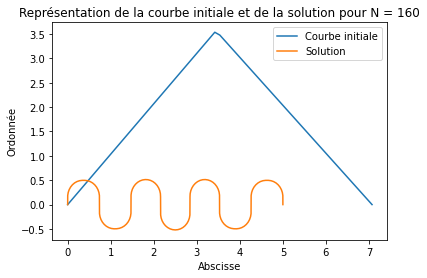

In [46]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution pour N = 160")

plt.plot(z0[0], z0[1], label="Courbe initiale")
plt.plot(sol3[0][:], sol3[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

In [47]:
somme1 = terme(sol3, N = 160)

##### Cas N = 260

In [48]:
sol4 = resol_pb(N = 260, K = 100000)[0]

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1043
Number of nonzeros in inequality constraint Jacobian.:     2075
Number of nonzeros in Lagrangian Hessian.............:     1560

Total number of variables............................:      522
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      263
Total number of inequality constraints...............:      520
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      519

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  88  2.5143079e+00 1.26e-07 2.34e-06  -8.6 3.28e-04  -2.2 1.00e+00 1.00e+00f  1
  89  2.5133521e+00 3.66e-06 3.89e-06  -8.6 1.76e-03  -2.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.5129793e+00 4.92e-07 3.96e-06  -8.6 6.72e-04  -2.2 1.00e+00 1.00e+00h  1
  91  2.5119061e+00 5.31e-06 1.18e-05  -8.6 1.80e-03  -2.7 1.00e+00 9.60e-01h  1
  92  2.5114671e+00 4.95e-07 3.46e-06  -8.6 6.59e-04  -2.3 1.00e+00 1.00e+00f  1
  93  2.5104504e+00 2.53e-06 1.41e-04  -8.6 2.32e-03  -2.8 1.00e+00 7.65e-01h  1
  94  2.5099397e+00 2.58e-07 3.39e-04  -8.6 6.87e-04  -2.3 7.98e-01 1.00e+00f  1
  95  2.5087980e+00 7.92e-06 3.10e-04  -8.6 3.24e-03  -2.8 9.64e-01 7.40e-01h  1
  96  2.5084061e+00 4.83e-06 2.29e-04  -8.6 1.10e-03  -2.4 1.00e+00 6.60e-01f  1
  97  2.5066542e+00 8.95e-06 4.58e-04  -8.6 2.92e-03  -2.9 6.32e-01 1.00e+00f  1
  98  2.5059585e+00 1.09e-06 1.31e-05  -8.6 9.14e-04  -2.4 9.81e-01 1.00e+00h  1
  99  2.5046596e+00 5.08e-06

 203  2.2619270e+00 1.14e-06 5.08e-04  -8.6 1.92e-03  -2.9 8.64e-01 1.00e+00f  1
 204  2.2604438e+00 1.69e-06 1.43e-03  -8.6 6.47e-03  -3.3 7.41e-01 3.10e-01h  1
 205  2.2584685e+00 4.61e-06 1.27e-03  -8.6 3.97e-02  -3.8 1.06e-01 1.39e-01f  1
 206  2.2567589e+00 2.70e-06 6.41e-04  -8.6 6.39e-03  -3.4 4.49e-01 3.50e-01f  1
 207  2.2548655e+00 2.27e-06 1.40e-05  -8.6 3.13e-03  -3.0 9.88e-01 1.00e+00f  1
 208  2.2524974e+00 1.83e-06 9.43e-04  -8.6 8.33e-03  -3.4 8.50e-01 4.32e-01h  1
 209  2.2504233e+00 1.37e-06 3.85e-06  -8.6 3.40e-03  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.2461067e+00 7.21e-06 4.95e-04  -8.6 9.28e-03  -3.5 5.06e-01 6.72e-01h  1
 211  2.2446242e+00 9.10e-06 1.70e-03  -8.6 3.92e-03  -3.1 1.00e+00 5.81e-01f  1
 212  2.2432826e+00 5.63e-06 1.24e-03  -8.6 1.05e-02  -3.5 2.35e-01 2.14e-01f  1
 213  2.2407171e+00 7.19e-06 4.98e-06  -8.6 5.34e-03  -3.1 1.00e+00 1.00e+00f  1
 214  2.2398213e+00 1.01e-05

 314  1.9863428e+00 6.60e-06 1.73e-03  -8.6 5.69e-02  -4.3 2.63e-01 1.64e-02f  1
 315  1.9801046e+00 1.10e-05 1.08e-03  -8.6 2.27e-02  -3.9 6.64e-01 5.39e-01f  1
 316  1.9766502e+00 2.62e-06 1.02e-03  -8.6 7.08e-03  -3.5 4.90e-01 7.93e-01f  1
 317  1.9754405e+00 2.34e-06 8.66e-04  -8.6 3.45e-02  -4.0 1.81e-01 1.05e-01f  1
 318  1.9710791e+00 6.00e-06 3.10e-06  -8.6 1.09e-02  -3.5 1.00e+00 1.00e+00f  1
 319  1.9696558e+00 1.20e-05 8.52e-05  -8.6 2.40e-02  -4.0 1.31e-01 1.14e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.9681270e+00 7.23e-06 2.13e-03  -8.6 8.10e-03  -3.6 5.74e-01 3.97e-01f  1
 321  1.9622916e+00 7.30e-06 2.69e-03  -8.6 3.91e-02  -4.1 8.12e-02 4.41e-01f  1
 322  1.9610031e+00 5.59e-06 3.61e-03  -8.6 1.23e-02  -3.6 1.26e-01 2.82e-01f  1
 323  1.9588972e+00 9.93e-07 6.44e-06  -8.6 4.69e-03  -3.2 1.00e+00 1.00e+00f  1
 324  1.9566531e+00 4.79e-06 7.77e-04  -8.6 1.53e-02  -3.7 9.66e-01 3.49e-01h  1
 325  1.9541297e+00 4.22e-06

 426  1.5217169e+00 7.57e-07 2.31e-03  -8.6 7.72e-03  -3.6 3.22e-01 5.98e-01f  1
 427  1.5096262e+00 5.87e-06 2.00e-03  -8.6 2.31e-02  -4.1 1.00e+00 5.80e-01f  1
 428  1.4994688e+00 4.10e-06 1.15e-03  -8.6 6.87e-02  -4.6 3.03e-01 1.65e-01f  1
 429  1.4807106e+00 3.28e-06 3.24e-03  -8.6 2.59e-02  -4.1 2.79e-01 8.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.4693639e+00 5.89e-06 2.72e-03  -8.6 9.21e-02  -4.6 1.64e-01 1.61e-01f  1
 431  1.4570337e+00 4.20e-06 1.51e-03  -8.6 2.87e-02  -4.2 5.17e-01 4.69e-01f  1
 432  1.4502450e+00 4.00e-06 2.01e-03  -8.6 1.08e-02  -3.8 3.45e-01 6.99e-01f  1
 433  1.4343077e+00 6.96e-06 8.67e-04  -8.6 3.24e-02  -4.2 5.20e-01 5.56e-01f  1
 434  1.4205669e+00 5.62e-06 1.12e-03  -8.6 9.57e-02  -4.7 8.02e-02 1.65e-01f  1
 435  1.4048641e+00 7.42e-06 2.97e-03  -8.6 3.62e-02  -4.3 2.41e-01 5.00e-01f  1
 436  1.4020598e+00 5.85e-06 2.25e-03  -8.6 1.36e-02  -3.9 1.97e-01 2.39e-01f  1
 437  1.3851793e+00 4.14e-05

 534  2.2752413e-01 2.96e-06 6.98e-04  -8.6 1.83e-01  -5.5 1.95e-01 1.39e-01f  1
 535  2.1266496e-01 3.55e-06 8.33e-04  -8.6 7.11e-02  -5.0 4.00e-01 7.57e-01f  1
 536  2.0836293e-01 5.54e-06 8.39e-04  -8.6 2.58e-01  -5.5 7.26e-02 8.51e-02f  1
 537  1.9979037e-01 5.10e-06 7.68e-04  -8.6 3.78e-01  -6.0 8.70e-02 8.32e-02f  1
 538  1.9935745e-01 5.10e-06 7.17e-04  -8.6 4.55e-01  -5.6 5.52e-03 9.26e-03f  1
 539  1.9919649e-01 5.18e-06 6.84e-04  -8.6 4.56e+01  -6.0 1.18e-05 5.14e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.9932393e-01 5.18e-06 1.32e-03  -8.6 6.72e+00  -5.6 1.74e-03 4.83e-04f  2
 541  1.8851095e-01 6.35e-06 1.54e-03  -8.6 9.43e-02  -5.2 1.61e-01 4.83e-01h  1
 542  1.8075262e-01 2.80e-06 1.05e-03  -8.6 3.75e-02  -4.8 3.50e-01 9.33e-01f  1
 543  1.7957835e-01 1.85e-06 6.05e-04  -8.6 1.56e-02  -4.3 3.47e-01 3.89e-01f  1
 544  1.7360554e-01 2.07e-06 2.22e-04  -8.6 3.94e-02  -4.8 8.13e-01 6.92e-01f  1
 545  1.6464611e-01 2.35e-06

 635  4.8577133e-02 2.63e-06 7.24e-05  -8.6 5.40e-02    -  3.05e-01 2.40e-01f  2
 636  4.8572988e-02 3.92e-06 1.12e-04  -8.6 5.67e-02    -  4.95e-01 2.13e-01h  2
 637  4.8572451e-02 4.10e-06 1.89e-04  -8.6 7.17e-01    -  3.24e-02 6.41e-03h  4
 638  4.8547150e-02 5.29e-07 7.37e-08  -8.6 7.71e-04  -4.8 1.00e+00 1.00e+00h  1
 639  4.8544129e-02 5.45e-07 1.83e-04  -8.6 5.34e-02    -  6.03e-01 8.15e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  4.8544658e-02 9.34e-09 2.20e-08  -8.6 6.57e-04  -5.3 1.00e+00 1.00e+00h  1
 641  4.8531999e-02 7.87e-07 1.95e-04  -9.0 1.15e-01    -  2.32e-01 6.87e-02h  3
 642  4.8349432e-02 1.79e-07 1.37e-07  -9.0 2.00e-03  -5.7 1.00e+00 1.00e+00h  1
 643  4.8344432e-02 5.42e-07 9.05e-05  -9.0 2.55e-01    -  1.05e-01 2.12e-02h  3
 644  4.8180085e-02 3.84e-07 6.80e-09  -9.0 2.96e-03  -6.2 1.00e+00 1.00e+00h  1
 645  4.8182034e-02 5.95e-07 7.33e-05  -9.0 2.32e-02    -  8.41e-01 2.45e-01h  3
 646  4.8188809e-02 1.97e-08

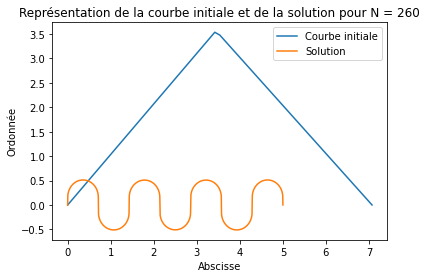

In [49]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution pour N = 260")

plt.plot(z0[0], z0[1], label="Courbe initiale")
plt.plot(sol4[0][:], sol4[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

In [50]:
somme2 = terme(sol4, N = 260)

##### Comparaison des solutions

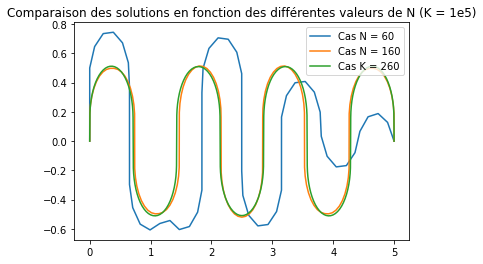

In [51]:
plt.title("Comparaison des solutions en fonction des différentes valeurs de N (K = 1e5)")

plt.plot(sol2[0][:], sol2[1][:], label="Cas N = 60")
plt.plot(sol3[0][:], sol3[1][:], label="Cas N = 160")
plt.plot(sol4[0][:], sol4[1][:], label="Cas K = 260")

plt.legend()
plt.show()

In [52]:
print(f"Pour N = 60, on obtient {somme0}")
print(f"Pour N = 160, on obtient {somme1}")
print(f"Pour N = 260, on obtient {somme2}")

Pour N = 60, on obtient 0.2832522868093431
Pour N = 160, on obtient 0.07766781182087969
Pour N = 260, on obtient 0.04817559854828671


On constate deux choses en augmentant la valeur de $N$: 
- les courbes se rapprochent de l'axe des abscisses et gagnent en régularité (logique, on augmente le nombre de points).
- la valeur du terme $dx^2\sum_{i=0}^{N}y_i^2$ est décroissante selon $N$, ce qui est en accord avec le constat précédent (le terme ci-avant calcule "l'éloignement cumulé" du tuyau à l'axe des abscisses).

En augmentant le nombre de points de discrétisation du tuyau, on peut plus facilement le "faire changer de trajectoire", il est alors plus aisé de le garder proche de l'axe des abscisses.

#### Question 9 :

In [53]:
# on réecrit l'algorithme, en changeant la condition initiale :

# déclaration des variables
N = 60
K = 10
gamma = 3
dx = L/N

# déclaration du solveur et de la variable de décision

opti = casadi.Opti();
z = opti.variable(2, N+1)

# définition de la fonction à minimiser

f = K*(z[0,-1] - L/2)**2
for i in range(N+1):
    f += (dx*z[1,i])**2

# optimisation sous contraintes

opti.minimize(f)

for i in range(N):
    opti.subject_to((z[0,i+1]-z[0,i])**2 + (z[1,i+1]-z[1,i])**2 - dx**2 == 0)
    opti.subject_to(z[0,i]-z[0,i+1] <= 0)
    if i != 0:
        opti.subject_to((z[0,i+1]-2*z[0,i]+z[0,i-1])**2+(z[1,i+1]-2*z[1,i]+z[1,i-1])**2-(dx**4)*(gamma**2) <= 0)

opti.subject_to(z[1,-1] == 0)
opti.subject_to(z[0,0] == 0)
opti.subject_to(z[1,0] == 0)
opti.subject_to(z[1,1] >= 0)

# déclaration de la condition initiale : le tuyau d'arrosage est déplié sur toute sa longueur
z1 = np.array([np.linspace(0, L, N+1), np.zeros(N+1)])

opti.set_initial(z, z1)

# choix du solveur
opti.solver('ipopt')

# on laisse la magie opérer
sol5 = opti.solve().value(z)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      475
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 127  2.3131725e+02 1.69e-04 3.14e+00  -1.7 7.89e-03   2.6 1.00e+00 1.00e+00f  1
 128  2.3103571e+02 5.23e-06 3.83e+00  -1.7 3.76e-03   3.0 1.00e+00 1.00e+00f  1
 129  2.3014490e+02 1.57e-04 8.80e+00  -1.7 2.42e-02   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.2954337e+02 6.28e-05 1.32e+01  -1.7 1.49e-02   3.0 1.00e+00 1.00e+00f  1
 131  2.2925234e+02 1.07e-05 1.47e+01  -1.7 6.10e-03   3.4 1.00e+00 1.00e+00f  1
 132  2.2820276e+02 2.38e-04 2.36e+01  -1.7 2.91e-02   2.9 1.00e+00 1.00e+00f  1
 133  2.2739502e+02 6.94e-05 2.32e+01  -1.7 1.17e-02   3.3 1.00e+00 1.00e+00f  1
 134  2.2449038e+02 4.83e-03 4.28e+01  -1.7 5.84e-02   2.9 2.82e-01 1.00e+00f  1
 135  2.2399402e+02 5.09e-03 4.84e+01  -1.7 1.98e-02   3.3 1.00e+00 2.64e-01f  1
 136  2.2118098e+02 5.44e-03 2.27e+01  -1.7 5.00e-02   2.8 1.00e+00 9.54e-01f  1
 137  2.2111758e+02 5.20e-03 1.06e+02  -1.7 1.03e-02   3.2 4.44e-01 6.53e-02h  1
 138  2.2003035e+02 2.29e-03

 274  3.1576032e-01 1.63e-04 1.08e-02  -2.5 3.24e-02  -1.1 1.00e+00 1.00e+00h  1
 275  3.0827403e-01 2.72e-03 4.45e-01  -3.8 2.86e-01  -1.6 3.41e-01 5.14e-01h  1
 276  3.0232833e-01 1.84e-03 7.02e-01  -3.8 1.83e-01    -  3.15e-01 5.15e-01h  1
 277  2.9560805e-01 1.66e-03 5.11e-01  -3.8 1.54e-01    -  3.86e-01 5.13e-01h  1
 278  2.9211030e-01 2.26e-03 4.93e-01  -3.8 1.65e+00  -2.1 3.65e-02 3.38e-02h  1
 279  2.8757732e-01 1.59e-03 3.63e-01  -3.8 2.12e-01    -  2.79e-01 3.15e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  2.8239745e-01 1.19e-03 2.81e-01  -3.8 9.93e-02    -  2.82e-01 3.81e-01h  1
 281  2.7507388e-01 5.61e-04 1.98e-02  -3.8 5.03e-02  -0.7 9.49e-01 1.00e+00f  1
 282  2.7005472e-01 1.21e-03 2.49e-02  -3.8 1.18e-01  -1.2 4.76e-01 6.68e-01h  1
 283  2.6758902e-01 4.80e-03 2.77e-02  -3.8 8.10e-01  -1.7 7.14e-02 6.01e-02f  1
 284  2.6564567e-01 8.97e-04 1.26e-02  -3.8 3.91e-02  -1.3 5.12e-01 5.38e-01f  1
 285  2.6282911e-01 5.71e-04

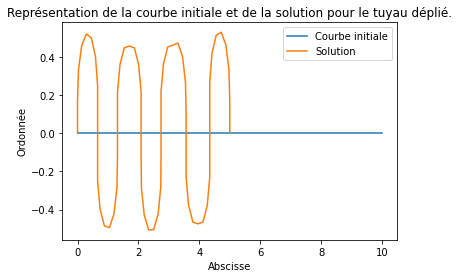

In [54]:
# affichage de la solution
# on affiche la solution ainsi que l'état initial

plt.title("Représentation de la courbe initiale et de la solution pour le tuyau déplié.")

plt.plot(z1[0], z1[1], label="Courbe initiale")
plt.plot(sol5[0][:], sol5[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

plt.legend()
plt.show()

##### Comparaison des deux résultats

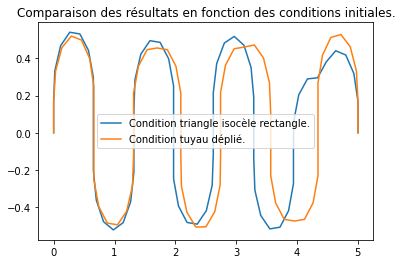

In [55]:
plt.title("Comparaison des résultats en fonction des conditions initiales.")

plt.plot(sol[0][:], sol[1][:], label="Condition triangle isocèle rectangle.")
plt.plot(sol5[0][:], sol5[1][:], label = "Condition tuyau déplié.")

plt.legend()
plt.show()

On constate qu'en partant de la position "tuyau déplié", la solution obtenue est plus régulière. Quoi qu'il en soit, on obtient deux solutions différentes.


Cela semble traduire le fait qu'il y a plusieurs minima à ce problème, qui n'est donc pas convexe.
La fonction considérée étant elle-même convexe, on en déduit donc que **l'ensemble des contraintes n'est pas convexe**.

### 3. Minimum global

#### Question 10 :

*A priori*, rajouter cette contrainte n'a pas de raison de rendre l'ensemble des contraintes convexes.
La caractéristique identifiée à la question précédente n'est donc pas modifiée.

En définissant la nouvelle contrainte : $c_{ineq_4}^i(z) = R^2 - (x_i - x_P)^2 - (y_i - y_P)^2$, pour $1 \leq i \leq N$ et en mettant à jour en conséquence la valeur de la fonction $c_{ineq}(z)$, on retrouve la formulation du problème d'optimisation.


In [92]:
# définition des nouvelles variables:

xp = 2
yp = 0.2
R = 0.3
N = 60
K = 10
dx = L/N

In [56]:
# définition du nouvel algorithme


# déclaration du solveur et de la variable de décision

opti = casadi.Opti()
z = opti.variable(2, N+1)

# définition de la fonction à minimiser

f = K*(z[0,-1] - L/2)**2
for i in range(N+1):
    f += (dx*z[1,i])**2

# optimisation sous contraintes

opti.minimize(f)

for i in range(N):
    opti.subject_to((z[0,i+1]-z[0,i])**2 + (z[1,i+1]-z[1,i])**2 - dx**2 == 0)
    opti.subject_to(z[0,i]-z[0,i+1] <= 0)
    if i != 0:
        opti.subject_to((z[0,i+1]-2*z[0,i]+z[0,i-1])**2+(z[1,i+1]-2*z[1,i]+z[1,i-1])**2-(dx**4)*(gamma**2) <= 0)
        
    # on rajoute la nouvelle contrainte
    opti.subject_to(((z[0, i] - xp)**2) + ((z[1, i] - yp)**2) - R**2 >= 0)

# puis au rang N
opti.subject_to(((z[0, N] - xp)**2) + ((z[1, N] - yp)**2) - R**2 >= 0)

opti.subject_to(z[1,-1] == 0)
opti.subject_to(z[0,0] == 0)
opti.subject_to(z[1,0] == 0)
opti.subject_to(z[1,1] >= 0)


opti.set_initial(z, z0)

# choix du solveur
opti.solver('ipopt')

# on laisse la magie opérer
sol6 = opti.solve().value(z)



This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 181  2.0645091e-01 1.69e-06 1.22e-04  -5.7 3.97e-03  -1.5 1.00e+00 1.00e+00h  1
 182  2.0631725e-01 1.54e-05 1.75e-02  -5.7 3.18e-02  -2.0 6.04e-01 1.00e+00H  1
 183  2.0628718e-01 2.15e-05 1.74e-03  -5.7 1.44e-02  -1.6 9.50e-01 1.00e+00h  1
 184  2.0624613e-01 2.64e-05 7.02e-02  -5.7 2.29e-01  -2.0 2.36e-01 3.06e-02h  1
 185  2.0619491e-01 4.67e-05 2.49e-02  -5.7 2.57e-02  -1.6 7.19e-01 4.13e-01f  1
 186  2.0616714e-01 4.48e-05 5.16e-02  -5.7 5.40e-02  -2.1 3.46e-01 8.42e-02f  1
 187  2.0610339e-01 5.95e-06 8.91e-03  -5.7 2.53e-03  -0.8 1.00e+00 8.69e-01f  1
 188  2.0609078e-01 5.31e-07 1.98e-04  -5.7 3.44e-03  -1.2 1.00e+00 1.00e+00f  1
 189  2.0606259e-01 2.86e-06 1.88e-04  -5.7 9.81e-03  -1.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.0601746e-01 9.48e-06 7.33e-03  -5.7 3.39e-02  -2.2 7.71e-01 6.33e-01h  1
 191  2.0600438e-01 4.98e-05 2.27e-02  -5.7 2.85e-01  -2.7 1.10e-01 2.47e-01f  1
 192  2.0599048e-01 4.44e-05

In [60]:
# maintenant pour la seconde condition initiale

# déclaration du solveur et de la variable de décision

opti = casadi.Opti()
z = opti.variable(2, N+1)

# définition de la fonction à minimiser

f = K*(z[0,-1] - L/2)**2
for i in range(N+1):
    f += (dx*z[1,i])**2

# optimisation sous contraintes

opti.minimize(f)

for i in range(N):
    opti.subject_to((z[0,i+1]-z[0,i])**2 + (z[1,i+1]-z[1,i])**2 - dx**2 == 0)
    opti.subject_to(z[0,i]-z[0,i+1] <= 0)
    if i != 0:
        opti.subject_to((z[0,i+1]-2*z[0,i]+z[0,i-1])**2+(z[1,i+1]-2*z[1,i]+z[1,i-1])**2-(dx**4)*(gamma**2) <= 0)
        
    # on rajoute la nouvelle contrainte
    opti.subject_to(((z[0, i] - xp)**2) + ((z[1, i] - yp)**2) - R**2 >= 0)
    
# puis au rang N
opti.subject_to(((z[0, N] - xp)**2) + ((z[1, N] - yp)**2) - R**2 >= 0)

opti.subject_to(z[1,-1] == 0)
opti.subject_to(z[0,0] == 0)
opti.subject_to(z[1,0] == 0)
opti.subject_to(z[1,1] >= 0)


opti.set_initial(z, z1)

# choix du solveur
opti.solver('ipopt')

# on laisse la magie opérer
sol7 = opti.solve().value(z)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

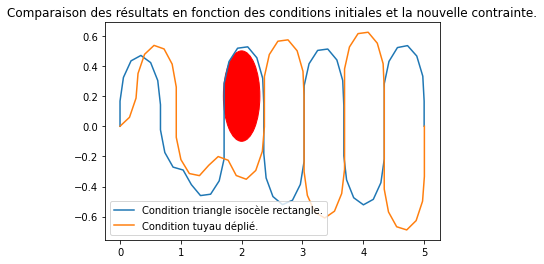

In [91]:
# on compare les deux solutions

fig, ax = plt.subplots()
plt.title("Comparaison des résultats en fonction des conditions initiales et la nouvelle contrainte.")

plt.plot(sol6[0][:], sol6[1][:], label="Condition triangle isocèle rectangle.")
plt.plot(sol7[0][:], sol7[1][:], label = "Condition tuyau déplié.")

parterre = plt.Circle((xp, yp), R, color="red")

ax.add_artist(parterre)

plt.legend()
plt.show()

En effet, on obtient de nouveau deux solutions différentes pour deux conditions initiales différentes. Cela confirme que notre problème n'est toujours pas convexe.

#### Question 12

- *(a)* En retirant une contrainte, on espère retrouver la convexité du problème. De plus, prendre des grandes valeurs de $K_1$ et $K_2$ permet de donner de l'importance à la condition d'arrivée sur le parterre de fleurs.
- *(b)* Réponse ci-après.

Le premier point (*ie.* $(x_0, y_0)$) est nécessairement $(0, 0)$ (sinon, impossible d'arroser !).

Ensuite, on procède par récurrence. On souhaite que le prochain point soit "à droite" du précédent (condition $x_{i+1} \ge x_i$) et à une distance de $dx$ de ce dernier(condition $(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2 = dx^2$). 

On va donc choisir un point sur le demi-cercle "orienté vers la droite" de centre le point précedent et de rayon dx.

On va donc avoir :

- $x_{i+1} = x_i + dx\cos(\theta)$
- $y_{i + 1} = y_i + dx\sin(\theta)$

avec $\theta \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ pris aléatoirement

Puis on va vérifier la condition de courbure et l'éloignement au parterre de fleurs avant de valider le nouveau point.

In [188]:
def CI_aleatoires(xp = 2, yp = 0.2, R = 0.3, gamma = 3):
    
    z0 = np.zeros((2, N+1), dtype = "float")
    pointeur = 1
    
    # en raison de la condition de courbure, on traite le cas i=1 à part 
    
    valide = False
    
    while not(valide):
        theta = (np.pi/2)*np.random.random() # on récupère un theta aléatoire, on veut toutefois y_1 >=0 à cause du robinet, d'où le theta entre 0 et pi/2

        # on initialise les nouvelles valeurs 
        x1 = dx*np.cos(theta)
        y1 = dx*np.sin(theta)
        
        
        # on teste la "condition parterre"
        if ((((x1 - xp)**2) + ((y1-yp)**2)) >= R**2):
            valide = True
    z0[0][1], z0[1][1] = x1, y1

    for i in range(1, N):
        
        valide = False
        parterre = False
        courbure = False
        iter = 0
        while not(valide):
            iter += 1
            # on calcule les points x_(i+1) et y_(i+1)
            # x_suivant correspond à x_(i+1), idem pour pour y_suivant

            theta = (np.pi/2)*(2*np.random.random() - 1) # on récupère un theta aléatoire
            
            # on initialise les nouvelles valeurs 
            x_suivant = z0[0][i] + dx*np.cos(theta)
            y_suivant = z0[1][i] + dx*np.sin(theta)
            
            # on teste nos deux autres conditions
            
            # "condition parterre"
            if ((((x_suivant - xp)**2) + ((y_suivant - yp)**2)) >= R**2):
                parterre = True
            
            # condition de courbure
            if ((((x_suivant - 2*z0[0][i] + z0[0][i - 1])**2) + ((y_suivant - 2*z0[1][i] + z0[1][i-1])**2)) <= ((dx**4)*(gamma**2))):
                courbure = True
                
            # un point est valide si il remplit les deux conditions précédentes
            
            valide = courbure and parterre
            
        # arrivé ici, le point (x_suivant, y_suivant) est un bon candidat pour x_(i +1), y_(i+1)
        z0[0][i+1], z0[1][i+1] = x_suivant, y_suivant

    return z0

In [175]:
# j'admets que le nom n'est pas très synthétique...
# on prendra K1 = 10 et K2 = 100 (plus important d'avoir y_N proche de 0 comme on l'imposait précèdemment)

def resol_pb_CI_aleatoires(K1 = 10, K2 = 100, N = 60, gamma = 3, xp = 2, yp = 0.2, R = 0.3):
    
    # déclaration de dx
    dx = L/N
    
    # délcaration du solveur et de la variable de décision
    opti = casadi.Opti()
    z = opti.variable(2, N+1)
    
    # définition de la nouvelle fonction à minimiser
    f = K1*(z[0,-1] - L/2)**2 + K2*(z[1,-1]**2)
    for i in range(N+1):
        f += (dx*z[1,i])**2
        
    # optimisation sous contraintes
    opti.minimize(f)
    
    # on définit les contraintes
    for i in range(N):
        opti.subject_to((z[0,i+1]-z[0,i])**2 + (z[1,i+1]-z[1,i])**2 - dx**2 == 0) # distance entre deux points
        opti.subject_to(z[0,i]-z[0,i+1] <= 0) # le tuyau doit avancer
        opti.subject_to(((z[0, i] - xp)**2) + ((z[1, i] - yp)**2) - R**2 >= 0) # distance au parterre
        if i != 0:
            opti.subject_to((z[0,i+1]-2*z[0,i]+z[0,i-1])**2+(z[1,i+1]-2*z[1,i]+z[1,i-1])**2-(dx**4)*(gamma**2) <= 0) # courbure

    # puis au rang N
    opti.subject_to(((z[0, N] - xp)**2) + ((z[1, N] - yp)**2) - R**2 >= 0)

    # contraintes imposées par le robinet
    opti.subject_to(z[0,0] == 0)
    opti.subject_to(z[1,0] == 0)
    opti.subject_to(z[1,1] >= 0)
    
    # on définit les CI aléatoires
    z0 = CI_aleatoires(xp, yp, R, gamma)
    
    opti.set_initial(z, z0)
    
    # choix du solveur
    opti.solver('ipopt')
    
    # notre travail est fini, au tour de casadi
    sol = opti.solve()
    
    return sol.value(z), z0

##### Test de notre méthode

In [144]:
sol8, z2 = resol_pb_CI_aleatoires()

okay
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 

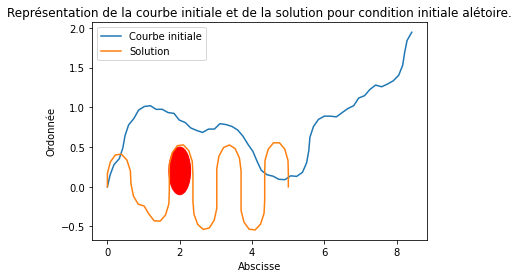

In [145]:
# affichage de la solution avec état initial aléatoire
# on affiche la solution ainsi que l'état initial

fig, ax = plt.subplots()

plt.title("Représentation de la courbe initiale et de la solution pour condition initiale alétoire.")

plt.plot(z2[0], z2[1], label="Courbe initiale")
plt.plot(sol8[0][:], sol8[1][:], label="Solution")

plt.xlabel("Abscisse")
plt.ylabel("Ordonnée")

parterre = plt.Circle((xp, yp), R, color="red")

ax.add_artist(parterre)

plt.legend()
plt.show()

On compare 4 résultats obtenus

In [139]:
rand1, init1 = resol_pb_CI_aleatoires()

okay
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 

In [140]:
rand2, init2 = resol_pb_CI_aleatoires()

okay
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 


Number of objective function evaluations             = 180
Number of objective gradient evaluations             = 128
Number of equality constraint evaluations            = 180
Number of inequality constraint evaluations          = 180
Number of equality constraint Jacobian evaluations   = 128
Number of inequality constraint Jacobian evaluations = 128
Number of Lagrangian Hessian evaluations             = 127
Total CPU secs in IPOPT (w/o function evaluations)   =      0.210
Total CPU secs in NLP function evaluations           =      0.061

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.12ms ( 11.78us)   2.17ms ( 12.04us)       180
       nlp_g  |  15.37ms ( 85.38us)  15.40ms ( 85.56us)       180
  nlp_grad_f  |   2.37ms ( 18.36us)   2.32ms ( 17.97us)       129
  nlp_hess_l  |  15.60ms (122.83us)  15.66ms (123.29us)       127
   nlp_jac_g  |  22.37ms (173.39us)  22.39ms (173.53us)       129
       total  | 281.58ms (2

In [141]:
rand3, init3 = resol_pb_CI_aleatoires()

okay
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 

In [151]:
rand4, init4 = resol_pb_CI_aleatoires()


okay
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 

  87  2.2636681e-01 4.08e-04 1.95e-01  -3.8 4.75e-01  -2.7 2.10e-01 1.19e-01h  2
  88  2.2548489e-01 4.22e-04 2.69e-01  -3.8 2.05e-01  -2.2 6.24e-01 1.53e-01h  2
  89  2.2305578e-01 1.43e-04 1.57e-03  -3.8 1.04e-01  -1.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.2219472e-01 1.62e-04 2.66e-02  -3.8 6.59e-01    -  8.80e-02 1.17e-01h  2
  91  2.2163126e-01 1.70e-04 1.56e-01  -3.8 9.68e-01    -  2.07e-01 4.62e-02h  2
  92  2.2066101e-01 1.67e-04 1.35e-01  -3.8 2.42e-01    -  3.49e-01 2.84e-01h  2
  93  2.1809391e-01 4.13e-04 3.09e-02  -3.8 2.36e-01  -2.3 7.72e-01 7.49e-01H  1
  94  2.1639099e-01 4.91e-04 8.16e-02  -3.8 1.54e-01  -1.9 1.00e+00 7.91e-01f  1
  95  2.1567141e-01 4.53e-04 2.60e-01  -3.8 2.47e-01    -  5.68e-01 1.89e-01f  1
  96  2.1532953e-01 8.93e-04 2.88e-01  -3.8 9.23e-01  -2.3 1.04e-01 2.09e-01F  1
  97  2.1444300e-01 5.09e-04 1.55e-01  -3.8 1.83e-01    -  5.66e-01 4.81e-01f  1
  98  2.1475772e-01 4.57e-04

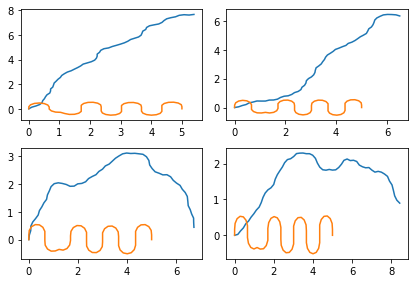

In [154]:
fig, ax = plt.subplots(2, 2)

parterre = plt.Circle((xp, yp), R, color="red")

ax[0][0].plot(init1[0], init1[1])
ax[0][0].plot(rand1[0][:], rand1[1][:])

ax[1][0].plot(init2[0], init2[1])
ax[1][0].plot(rand2[0][:], rand2[1][:])

ax[0][1].plot(init3[0], init3[1])
ax[0][1].plot(rand3[0][:], rand3[1][:])

ax[1][1].plot(init4[0], init4[1])
ax[1][1].plot(rand4[0][:], rand4[1][:])


fig.tight_layout()
plt.show()

On cherche maintenant le minimum global de cette fonction.

On va donc générer aléatoirement $n$ conditions initiales différentes, et obtenir le minimum des minima obtenus.

On espère ainsi approcher le minimum de la fonction.

In [179]:
K1, K2, N = 10, 100, 60

def func(z):
    
    res = K1*(z[0,-1] - L/2)**2 + K2*(z[1,-1]**2)
    
    for i in range(N+1):
        res += (dx*z[1,i])**2
        
    return res

In [189]:
def calc_min(n = 10):
    
    candidat = 1000000
    
    for i in range(n):
        
        z = resol_pb_CI_aleatoires()[0]
        challenger = func(z)
        
        if challenger<=candidat:
            candidat = challenger
            
    return candidat

In [194]:
candidat = calc_min()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 106  3.7519023e-01 3.45e-03 2.47e-01  -3.8 7.34e-01    -  2.19e-01 5.43e-01h  1
 107  3.6824480e-01 4.94e-03 2.27e-01  -3.8 1.16e+01  -4.2 4.14e-02 3.36e-02h  1
 108  3.6132771e-01 6.13e-03 2.37e-01  -3.8 2.31e+01  -3.8 1.76e-02 1.07e-02h  1
 109  3.5336995e-01 8.20e-03 2.14e-01  -3.8 3.00e+00    -  4.00e-02 1.29e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.4882354e-01 8.26e-03 2.43e-01  -3.8 2.27e+00  -3.3 1.97e-01 6.32e-02h  1
 111  3.3843014e-01 5.44e-03 1.30e-01  -3.8 4.11e-01  -2.9 4.98e-01 3.74e-01h  1
 112  3.3570178e-01 5.82e-03 1.54e-01  -3.8 8.42e+00  -3.4 5.41e-02 2.08e-02h  2
 113  3.3356142e-01 6.42e-03 1.35e-01  -3.8 1.45e+01  -3.9 2.73e-02 1.53e-02h  2
 114  3.1496980e-01 1.45e-03 1.30e-02  -3.8 2.10e-01  -2.5 1.00e+00 8.71e-01h  1
 115  3.1420730e-01 2.75e-03 6.90e-02  -3.8 6.17e-01    -  2.86e-01 5.50e-01h  1
 116  3.1177387e-01 2.75e-03 6.42e-02  -3.8 1.91e+01    -  4.11e-02 1.06e-02h  2
 117  3.0936039e-01 2.46e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 111  2.5676269e-01 2.22e-03 1.05e-01  -5.7 1.70e-01    -  6.13e-01 3.19e-01h  1
 112  2.5480138e-01 2.19e-03 9.49e-02  -5.7 6.51e+00  -3.2 2.71e-02 1.85e-02h  1
 113  2.5342163e-01 1.60e-03 3.84e-02  -5.7 2.11e-01  -2.8 1.84e-01 2.95e-01h  1
 114  2.5296798e-01 1.54e-03 3.75e-02  -5.7 4.21e-01    -  4.67e-02 4.16e-02h  1
 115  2.5233911e-01 1.48e-03 3.27e-02  -5.7 8.01e-01  -3.3 1.32e-01 3.92e-02f  1
 116  2.5154003e-01 1.48e-03 3.21e-02  -5.7 3.55e+00  -3.8 1.16e-02 1.11e-02h  1
 117  2.5028873e-01 1.42e-03 3.65e-02  -5.7 1.01e+00  -3.3 1.11e-01 5.42e-02f  1
 118  2.4639317e-01 1.40e-03 3.03e-02  -5.7 6.17e-01  -2.9 2.00e-01 3.35e-01f  1
 119  2.4244296e-01 9.27e-04 3.46e-02  -5.7 2.35e-01  -2.5 2.88e-01 5.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.4060309e-01 9.68e-04 4.22e-02  -5.7 1.11e+00  -3.0 3.82e-03 5.88e-02h  1
 121  2.3887370e-01 7.92e-04 3.12e-02  -5.7 1.90e-01  -2.5 2.39e-01 2.21e-01f  1
 122  2.3868723e-01 7.47e-04

  21  1.9512863e+02 9.74e-04 1.12e+01  -1.0 1.52e-01   1.7 1.00e+00 1.00e+00f  1
  22  1.4069564e+02 9.88e-03 3.65e+01  -1.0 4.03e-01   1.2 6.74e-01 9.83e-01f  1
  23  1.0355331e+02 1.73e-03 5.34e+01  -1.0 4.28e-01   0.7 4.74e-01 1.00e+00f  1
  24  1.0083545e+02 1.56e-04 5.51e+00  -1.0 3.29e-02   2.1 1.00e+00 1.00e+00h  1
  25  9.6394736e+01 2.38e-04 2.88e+00  -1.0 6.03e-02   1.6 1.00e+00 1.00e+00f  1
  26  9.3759722e+01 7.36e-03 1.50e+01  -1.0 1.48e+00   1.1 1.28e-01 9.43e-02f  1
  27  9.0762465e+01 1.31e-03 5.93e+00  -1.0 8.38e-02   1.5 1.00e+00 9.00e-01f  1
  28  8.5087769e+01 8.11e-04 2.62e+00  -1.0 1.37e-01   1.1 1.00e+00 9.52e-01f  1
  29  7.9762198e+01 5.73e-04 1.12e+00  -1.0 2.98e-01   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.8743652e+01 2.96e-02 2.79e+01  -1.0 7.35e+00   0.1 7.72e-02 1.29e-01f  1
  31  7.6950879e+01 3.10e-03 6.19e+00  -1.0 4.76e-01   0.5 1.00e+00 1.00e+00f  1
  32  7.3205945e+01 1.69e-03

  57  1.0026786e+01 5.87e-04 1.34e-01  -3.8 7.83e-02  -1.2 1.00e+00 5.41e-01f  1
  58  9.9291717e+00 2.65e-04 3.34e-03  -3.8 1.39e-01  -1.7 1.00e+00 1.00e+00f  1
  59  9.8311069e+00 5.06e-04 2.07e-02  -3.8 8.21e-01  -2.2 3.40e-01 2.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.7312274e+00 3.23e-03 1.53e-01  -3.8 3.21e-01  -1.8 3.50e-01 8.13e-01f  1
  61  9.7142874e+00 2.62e-03 8.26e-02  -3.8 1.36e-01  -1.3 8.70e-01 2.37e-01f  1
  62  9.6976285e+00 2.38e-03 9.07e-02  -3.8 4.04e-01  -1.8 6.59e-01 9.02e-02h  1
  63  9.6499223e+00 1.79e-04 1.49e-01  -3.8 1.14e-01  -1.4 4.72e-01 9.61e-01f  1
  64  9.6303312e+00 3.84e-05 4.69e-03  -3.8 4.23e-02  -1.0 1.00e+00 1.00e+00f  1
  65  9.5680875e+00 4.27e-04 3.55e-03  -3.8 9.61e-02  -1.4 1.00e+00 1.00e+00h  1
  66  9.5323798e+00 2.15e-03 3.57e-02  -3.8 1.57e+00  -1.9 1.85e-01 1.00e-01h  1
  67  9.4968679e+00 2.03e-03 1.37e-01  -3.8 1.22e+00  -2.4 1.94e-01 5.44e-02h  1
  68  9.4652533e+00 1.71e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  59  3.6352867e-01 1.75e-02 2.99e-01  -3.8 7.01e-01  -1.6 1.10e-01 1.97e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5183751e-01 1.24e-02 3.65e-01  -3.8 1.74e-01  -1.2 1.97e-01 3.11e-01h  1
  61  3.4406150e-01 8.25e-03 3.10e-01  -3.8 2.54e-01    -  3.31e-01 4.08e-01f  1
  62  3.3000861e-01 4.76e-03 2.00e-01  -3.8 2.60e-01  -1.6 3.79e-01 4.36e-01h  1
  63  3.2280320e-01 5.79e-03 1.93e-01  -3.8 3.13e+00  -2.1 5.03e-02 3.86e-02h  1
  64  3.1944310e-01 1.03e-02 1.48e-01  -3.8 3.07e-01  -1.7 2.24e-01 1.08e-01h  1
  65  3.1286055e-01 1.03e-02 1.55e-01  -3.8 2.94e+01    -  4.57e-03 3.45e-03h  1
  66  3.1023208e-01 6.80e-03 3.71e-01  -3.8 4.96e-01    -  5.85e-02 3.08e-01h  1
  67  3.0623406e-01 5.73e-03 5.44e-01  -3.8 3.70e-01  -1.3 2.83e-01 1.15e-01h  1
  68  3.0428961e-01 5.43e-03 4.44e-01  -3.8 6.70e-02  -0.8 8.74e-01 1.72e-01h  1
  69  2.9984774e-01 4.71e-03 5.30e-01  -3.8 3.98e-01  -1.3 3.64e-01 1.28e-01h  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 100  9.0698502e+00 2.66e-02 4.94e-01  -3.8 3.66e-01  -1.3 1.00e+00 9.86e-02f  1
 101  9.0122590e+00 2.04e-02 3.97e-01  -3.8 3.71e-01  -1.7 3.39e-01 2.52e-01f  1
 102  8.9711822e+00 1.03e-02 4.58e-01  -3.8 1.41e-01  -1.3 1.00e+00 5.57e-01f  1
 103  8.9553459e+00 9.63e-03 4.30e-01  -3.8 2.18e+00  -1.8 4.31e-02 6.58e-02h  1
 104  8.9027182e+00 3.71e-03 1.40e-01  -3.8 1.55e-01  -1.4 6.97e-01 6.70e-01f  1
 105  8.8921749e+00 2.41e-03 3.25e-01  -3.8 1.88e-01  -0.9 1.00e+00 3.47e-01f  1
 106  8.8795310e+00 1.07e-04 1.38e-02  -3.8 3.94e-02  -0.5 1.00e+00 1.00e+00f  1
 107  8.8559813e+00 1.24e-02 7.00e-01  -3.8 5.36e+00  -1.0 1.50e-02 6.46e-02h  1
 108  8.8356832e+00 1.26e-02 5.30e-01  -3.8 1.12e-01  -0.6 1.68e-01 3.64e-01f  1
 109  8.8206256e+00 9.97e-03 5.03e-01  -3.8 2.29e-01  -1.0 1.00e+00 1.59e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.7742196e+00 6.24e-03 5.12e-01  -3.8 3.13e-01  -1.5 8.17e-01 4.04e-01f  1
 111  8.7256088e+00 1.40e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      597
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      119

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [195]:
print(candidat)

0.20333156832405488
